In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Function
import optuna
from modules import Trainer
from modules.competition_dataset import EEGDataset
from modules.utils import evaluate_model
import random
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/ai_data/eeg_detection/data/mtcaic3'
# model_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/models/ssvep.pth'
# optuna_db_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/optuna/optuna_studies.db'
data_path = './data/mtcaic3'
model_path = './checkpoints/mi/models/the_honored_one.pth'
optuna_db_path = './checkpoints/mi/optuna/the_honored_one.db'
eeg_channels = [
    "C3", # 2296.15
    "PZ", # 1744.43
    "C4", # 1556.46
    "OZ", # 444.98
    "PO7", # 381.63
    "PO8", # 275.78
    "CZ", # 200.43
    "FZ", # 111.51
]

In [21]:
# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call this function before creating datasets and models
set_random_seeds(42)

In [22]:
window_length = 128 * 2 # ensure divisble by 64 the kernel size
stride = window_length // 3
batch_size = 64

dataset_train = EEGDataset(
    data_path,
    window_length=window_length,
    stride=stride,
    domain="time",
    data_fraction=0.2,
    hardcoded_mean=True,
    task="mi",
    eeg_channels=eeg_channels,
)

dataset_val = EEGDataset(
    data_path=data_path,
    window_length=window_length,
    stride=stride,
    split='validation',
    read_labels=True,
    hardcoded_mean=True,
    data_fraction=1,
    task="mi",
    eeg_channels=eeg_channels,
)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=batch_size)

task: mi, split: train, domain: time, data_fraction: 0.2
Using 20.0% of data: 480/480 samples
skipped: 1/480
task: mi, split: validation, domain: time, data_fraction: 1
skipped: 0/50


In [33]:
dataset_train[0][0].shape

torch.Size([8, 40, 256])

In [37]:
# ---------------- Gradient Reversal Layer ---------------- #
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)


# ---------------- LSTM Head ---------------- #
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # x: B x seq_len x feat_dim
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])  # last time‐step


# ---------------- EEG Feature Extractor (3D) ---------------- #
class EEGFeatureExtractor3D(nn.Module):
    def __init__(self, n_electrodes, kernLength, F1, D, F2, dropout):
        super().__init__()
        # Input: B×C×F×T. After unsqueeze: B×1×C×F×T.
        # 1) Temporal+Spectral conv per electrode
        self.temporal_spec = nn.Sequential(
            nn.Conv3d(
                in_channels=1, out_channels=F1,
                kernel_size=(1,   5, kernLength),
                padding=(0,     2, kernLength//2),
                bias=False
            ),
            nn.BatchNorm3d(F1),
            nn.ELU(),
        )
        # 2) Depthwise spatial conv across electrodes
        self.spatial = nn.Sequential(
            nn.Conv3d(
                in_channels=F1, out_channels=F1*D,
                kernel_size=(n_electrodes, 1, 1),
                groups=F1, bias=False
            ),
            nn.BatchNorm3d(F1*D),
            nn.ELU(),
            nn.MaxPool3d((1,1,2)),  # half the time‐axis
            nn.Dropout(dropout),
        )
        # 3) Separable freq‐time conv
        self.separable = nn.Sequential(
            nn.Conv3d(
                in_channels=F1*D, out_channels=F1*D,
                kernel_size=(1, 7, 16),
                padding=(0, 3, 8),
                groups=F1*D, bias=False
            ),
            nn.Conv3d(
                in_channels=F1*D, out_channels=F2,
                kernel_size=1, bias=False
            ),
            nn.BatchNorm3d(F2),
            nn.ELU(),
            nn.MaxPool3d((1,1,2)),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: B×C×F×T
        B, C, F, T = x.shape
        x = x.unsqueeze(1)         # → B×1×C×F×T
        x = self.temporal_spec(x)  # → B×F1×C×F×T_sub
        x = self.spatial(x)        # → B×(F1·D)×1×F×T_sub
        x = self.separable(x)      # → B×F2×1×F'×T_sub2

        # squeeze out the now‐unit “electrode” dim
        x = x.squeeze(2)           # B×F2×F'×T_sub2
        B, F2, Fp, Tp = x.shape

        # merge frequency into the feature axis:
        x = x.view(B, F2*Fp, Tp)   # B×feat_dim×T_sub2
        # finally, transpose for LSTM: B×T_sub2×feat_dim
        return x.permute(0, 2, 1)

# ---------------- MDD SSVEP Classifier ----------------
class MDD_SSVEPClassifier(nn.Module):
    def __init__(self, n_electrodes=16, out_dim=4, extractor_kwargs={}, lstm_kwargs={}):
        super().__init__()
        # shared feature extractor
        self.feature_extractor = EEGFeatureExtractor3D(**extractor_kwargs)

        # two label predictors
        feat_dim = lstm_kwargs["input_dim"]
        self.F  = LSTMModel(**lstm_kwargs)   # classifier F
        self.Fp = LSTMModel(**lstm_kwargs)   # classifier F'

    def forward(self, x):
        # x: B×C×F×T
        seq = self.feature_extractor(x)    # → B×T_sub×feat_dim
        out1 = self.F(seq)                 # → B×out_dim
        out2 = self.Fp(seq)                # → B×out_dim
        return out1, out2
        
        

dummy_x = torch.randn(5, 8, 40, 256).to(device)
model = MDD_SSVEPClassifier(
    n_electrodes=8,
    out_dim=2,
    extractor_kwargs=dict(
      n_electrodes=8, kernLength=8, F1=8, D=2, F2=16, dropout=0.2621
    ),
    lstm_kwargs=dict(
      input_dim=16*(40//1), hidden_dim=256, layer_dim=1, output_dim=2
    )
).to(device)

print('worked dude')
model(dummy_x)

worked dude


(tensor([[-0.1134,  0.1328],
         [ 0.0219,  0.0477],
         [-0.1725, -0.0252],
         [ 0.0299, -0.0648],
         [-0.0670,  0.0718]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.0534,  0.0629],
         [ 0.0071, -0.0134],
         [ 0.1108,  0.0464],
         [ 0.0903, -0.0520],
         [-0.0199, -0.0208]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [38]:
avg_losses_label = []
avg_losses_domain = []
val_label_accuracies = []
val_domain_accuracies = []
train_label_accuracies = []
train_domain_accuracies = []

In [ ]:
# ——— pick your held-out subject(s) ———
# e.g. single subject index 29 (0-based):
target_subject = 29

# your EEGDataset stores the subject label in dataset.subjects (shape [N])
# build two index lists:
is_target = (dataset_train.subjects == target_subject)
target_indices = torch.nonzero(is_target, as_tuple=True)[0].tolist()
source_indices = torch.nonzero(~is_target, as_tuple=True)[0].tolist()

train_loader = DataLoader(
    Subset(dataset_train, source_indices),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)
target_loader = DataLoader(
    Subset(dataset_train, target_indices),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

In [40]:
try:
    model.load_state_dict(torch.load(model_path, weights_only=True))
except Exception:
    print("skipping model loading...")

lr = 0.0003746351873334935

opt_FE = torch.optim.Adam(model.feature_extractor.parameters(), lr=lr)
opt_F  = torch.optim.Adam(model.F.parameters(),               lr=lr)
opt_Fp = torch.optim.Adam(model.Fp.parameters(),              lr=lr)

criterion = nn.CrossEntropyLoss()
epochs = 200
domain_loss_weight = 1.0

# 3) Training loop with three MDD steps
for epoch in range(epochs):
    avg_loss_label  = 0.0
    avg_loss_domain = 0.0
    correct_label   = 0
    total           = 0

    model.train()
    model.to(device)

    # ——— A) Source classification ———
    for x_s, y_s in train_loader:
        x_s       = x_s.to(device)
        y_labels  = y_s[:, 0].to(device)

        out1, _   = model(x_s)
        loss_cls  = criterion(out1, y_labels)

        opt_FE.zero_grad(); opt_F.zero_grad()
        loss_cls.backward()
        opt_FE.step();  opt_F.step()

        avg_loss_label += loss_cls.item()
        _, pred = out1.max(1)
        correct_label  += (pred == y_labels).sum().item()
        total          += y_labels.size(0)

    # ——— B) Adversarially train F' to maximize margin ———
    for x_t, _ in target_loader:
        x_t = x_t.to(device)

        with torch.no_grad():
            logits_t, _ = model(x_t)
            yhat        = logits_t.argmax(dim=1)

        out2 = model.Fp(model.feature_extractor(x_t))
        top2 = out2.topk(2, dim=1).values
        margin      = top2[:, 1] - top2[:, 0]
        loss_max    = -(margin.mean())

        opt_Fp.zero_grad()
        loss_max.backward()
        opt_Fp.step()

    # ——— C) Train FE + F to minimize margin ———
    for x_t, _ in target_loader:
        x_t = x_t.to(device)

        _, out2_t = model(x_t)
        top2      = out2_t.topk(2, dim=1).values
        margin    = top2[:, 1] - top2[:, 0]
        loss_mdd  = margin.mean()

        avg_loss_domain += loss_mdd.item()

        opt_FE.zero_grad(); opt_F.zero_grad()
        loss_mdd.backward()
        opt_FE.step();  opt_F.step()

    # ——— Compute epoch metrics & checkpoint ———
    avg_loss_label  /= len(train_loader)
    avg_loss_domain /= len(target_loader)
    train_label_acc  = 100.0 * correct_label / total
    train_domain_acc = 0.0

    avg_losses_label.append(avg_loss_label)
    avg_losses_domain.append(avg_loss_domain)
    train_label_accuracies.append(train_label_acc)
    train_domain_accuracies.append(train_domain_acc)

    if (epoch + 1) % 5 == 0:
        label_eval, domain_eval = evaluate_model(model, val_loader, device)
        val_label_accuracies.append(label_eval)
        val_domain_accuracies.append(domain_eval)
        model.cpu()
        torch.save({
            "feature_extractor": model.feature_extractor.state_dict(),
            "F":                 model.F.state_dict(),
            "Fp":                model.Fp.state_dict(),
        }, model_path)
        print(
            f"{epoch}: avg_loss_label: {avg_loss_label:.3f}, "
            f"avg_loss_domain: {avg_loss_domain:.3f}, "
            f"train_label_acc: {train_label_acc:.2f}%, "
            f"train_domain_acc: {train_domain_acc:.2f}%, "
            f"label_evaluation: {(label_eval*100):.2f}%, "
            f"domain_evaluation: {(domain_eval*100):.2f}%, "
            f"lr: {opt_FE.param_groups[0]['lr']}"
        )

skipping model loading...
4: avg_loss_label: 0.648, avg_loss_domain: -0.107, train_label_acc: 60.82%, train_domain_acc: 0.00%, label_evaluation: 46.30%, domain_evaluation: 0.00%, lr: 0.0003746351873334935
9: avg_loss_label: 0.606, avg_loss_domain: -0.070, train_label_acc: 65.54%, train_domain_acc: 0.00%, label_evaluation: 51.72%, domain_evaluation: 0.00%, lr: 0.0003746351873334935
14: avg_loss_label: 0.582, avg_loss_domain: -0.072, train_label_acc: 68.60%, train_domain_acc: 0.00%, label_evaluation: 50.26%, domain_evaluation: 0.00%, lr: 0.0003746351873334935
19: avg_loss_label: 0.555, avg_loss_domain: -0.057, train_label_acc: 70.94%, train_domain_acc: 0.00%, label_evaluation: 53.70%, domain_evaluation: 0.00%, lr: 0.0003746351873334935
24: avg_loss_label: 0.535, avg_loss_domain: -0.047, train_label_acc: 72.19%, train_domain_acc: 0.00%, label_evaluation: 54.76%, domain_evaluation: 0.00%, lr: 0.0003746351873334935
29: avg_loss_label: 0.526, avg_loss_domain: -0.043, train_label_acc: 72.84%,

KeyboardInterrupt: 

Exception ignored in: <function _ConnectionBase.__del__ at 0x0000019187088540>
Traceback (most recent call last):
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\connection.py", line 133, in __del__
    self._close()
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000191FF8FA2A0>
Traceback (most recent call last):
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312

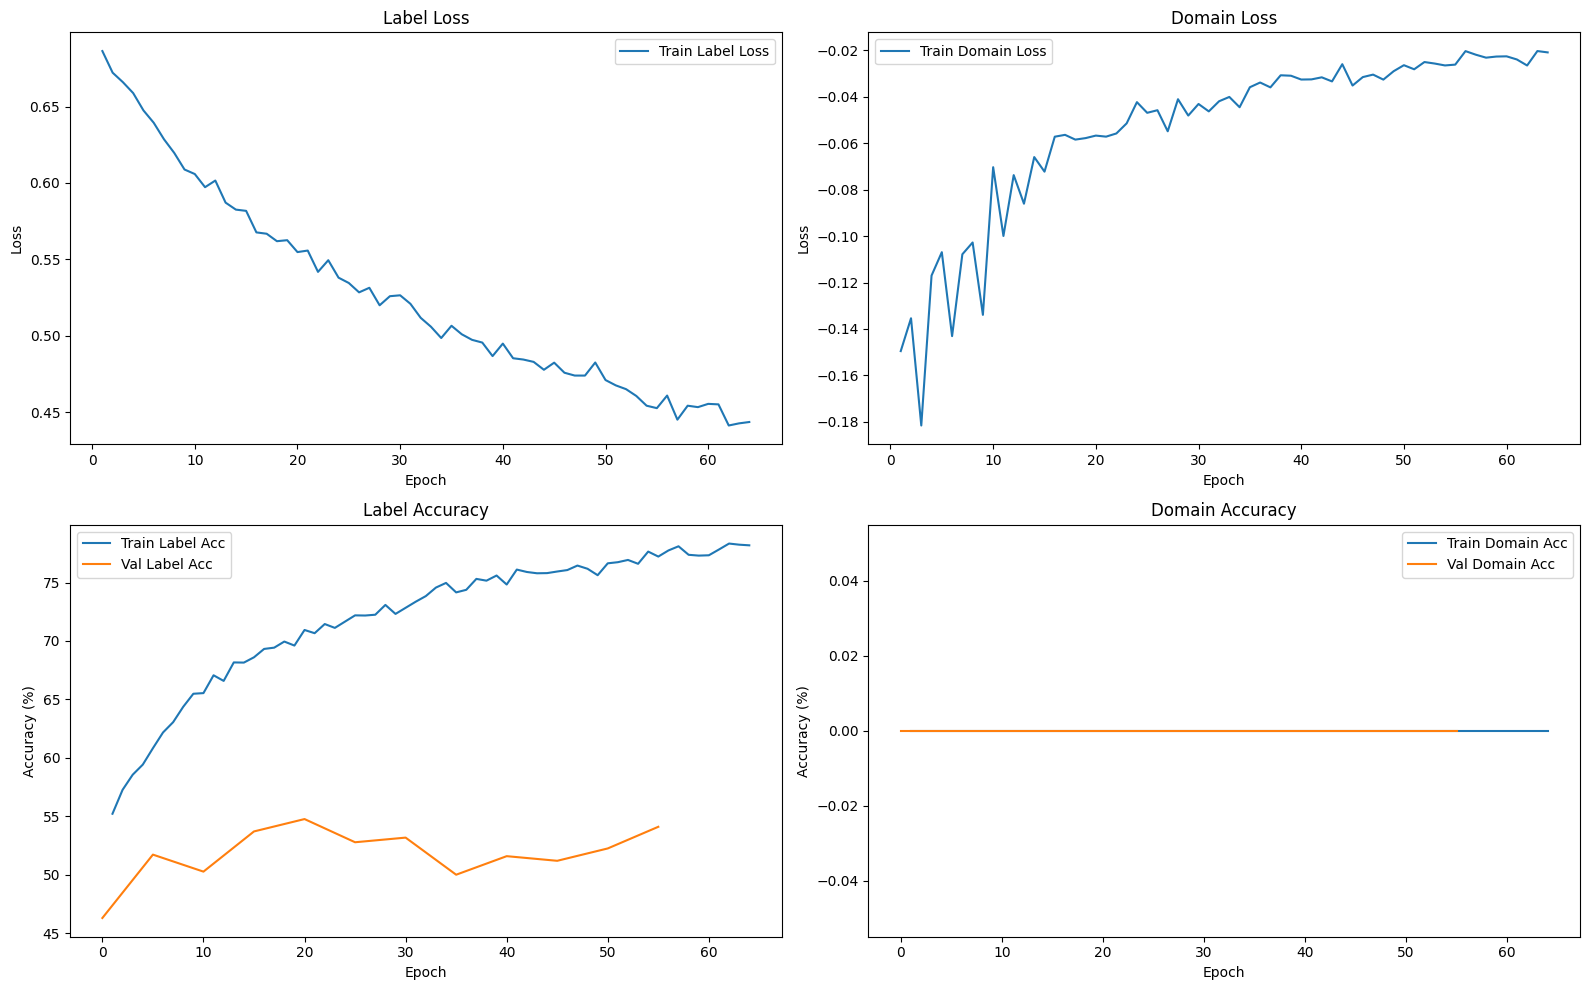

In [41]:
epochs = range(1, len(avg_losses_label) + 1)
val_epochs = range(0, len(val_label_accuracies) * 5, 5)  # if you log every 5 epochs

plt.figure(figsize=(16, 10))

# 1. Label Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, avg_losses_label, label='Train Label Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Label Loss')
plt.legend()

# 2. Domain Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, avg_losses_domain, label='Train Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Loss')
plt.legend()

# 3. Label Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_label_accuracies, label='Train Label Acc')
plt.plot(val_epochs, [v*100 for v in val_label_accuracies], label='Val Label Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Label Accuracy')
plt.legend()

# 4. Domain Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, train_domain_accuracies, label='Train Domain Acc')
plt.plot(val_epochs, [v*100 for v in val_domain_accuracies], label='Val Domain Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Domain Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CustomTrainer(Trainer):
    # Called by _objective during an Optuna trial
    def prepare_trial_run(self):
        assert isinstance(self.trial, optuna.Trial), "Trial not set!"

        # 1) Hyperparameter search space
        # Data params
        window_length = self.trial.suggest_categorical("window_length", [128, 256, 640])
        batch_size    = self.trial.suggest_categorical("batch_size", [32, 64])

        # Model extractor params (based on EEG3D+MDD)
        kernLength = self.trial.suggest_categorical("kernLength", [8, 16, 32, 64, 128])
        F1         = self.trial.suggest_categorical("F1", [8, 16, 32, 64])
        D          = self.trial.suggest_categorical("D", [1, 2, 4])
        F2         = self.trial.suggest_categorical("F2", [16, 32, 64, 128])
        dropout    = self.trial.suggest_float("dropout", 0.1, 0.5)
        # MDD head params
        hidden_dim = self.trial.suggest_categorical("hidden_dim", [64, 128, 256])
        layer_dim  = self.trial.suggest_int("layer_dim", 1, 3)
        # MDD alignment weight
        lambda_mdd = self.trial.suggest_float("lambda_mdd", 0.1, 1.0)

        # Optimizer
        lr = self.trial.suggest_float("lr", 1e-5, 1e-3, log=True)

        # 2) Prepare data
        super()._prepare_data(is_trial=True,
                              batch_size=batch_size,
                              window_length=window_length)

        # 3) Build MDD model
        extractor_kwargs = dict(
            n_electrodes=self.data.num_channels,
            kernLength=kernLength,
            F1=F1,
            D=D,
            F2=F2,
            dropout=dropout,
        )
        lstm_kwargs = dict(
            input_dim=F2 * (self.data.freq_bins // D),  # adjust if freq_bins variable
            hidden_dim=hidden_dim,
            layer_dim=layer_dim,
            output_dim=self.data.num_classes,
        )
        self.model = MDD_SSVEPClassifier(
            extractor_kwargs=extractor_kwargs,
            lstm_kwargs=lstm_kwargs
        ).to(self.device)
        self.lambda_mdd = lambda_mdd

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    # Called by train() for final run
    def prepare_final_run(self):
        study      = self._get_study()
        best       = study.best_params
        # Data
        super()._prepare_data(is_trial=False)
        # Build final model
        extractor_kwargs = dict(
            n_electrodes=self.data.num_channels,
            kernLength=best["kernLength"],
            F1=best["F1"],
            D=best["D"],
            F2=best["F2"],
            dropout=best["dropout"],
        )
        lstm_kwargs = dict(
            input_dim=best["F2"] * (self.data.freq_bins // best["D"]),
            hidden_dim=best["hidden_dim"],
            layer_dim=best["layer_dim"],
            output_dim=self.data.num_classes,
        )
        self.model = MDD_SSVEPClassifier(
            extractor_kwargs=extractor_kwargs,
            lstm_kwargs=lstm_kwargs
        ).to(self.device)
        # load weights?
        try:
            self.model.load_state_dict(torch.load(self.model_path))
            print(f"Loaded weights from {self.model_path}")
        except:
            print("No checkpoint found, training from scratch.")

        lr = best["lr"]
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max', factor=0.5, patience=20,
            threshold=1e-4, threshold_mode='rel',
            cooldown=0, min_lr=1e-6
        )

trainer = CustomTrainer(
        data_path=data_path,
        optuna_db_path=optuna_db_path,
        model_path=model_path,
        train_epochs=500, # Final training epochs
        tune_epochs=50,   # Epochs per trial
        optuna_n_trials=50,
        task="mi",
        eeg_channels=eeg_channels,
        data_fraction=0.4
    )

In [ ]:
delete_existing = False
trainer.optimize(delete_existing)

In [ ]:
trainer.train()

In [ ]:
trainer._prepare_training(False)
trainer.model.eval()
f"test accuracy: {evaluate_model(trainer.model, trainer.eval_loader, device)}"